In [2]:
import numpy as np

from scipy.linalg import solve

import matplotlib.pyplot as plt

In [3]:
def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x = np.cos(np.pi * row / N)
    c = ((1 + (col % N == 0)) * (-1) ** col).T
    X = np.ones(N + 1) * x
    dX = X - X.T
    D = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

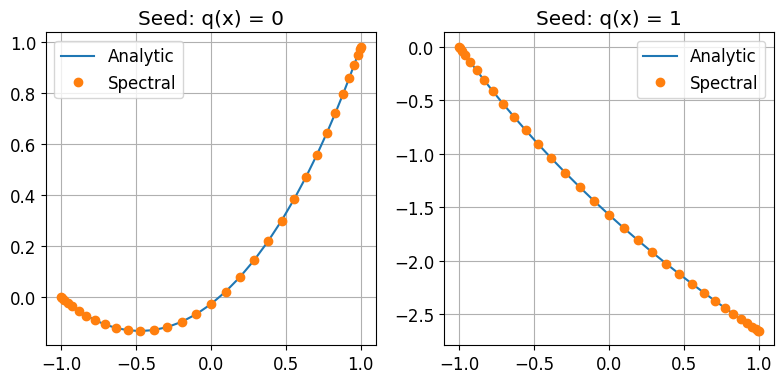

In [95]:
N = 32
x, D1, D2 = ChebyshevD(N)
I = np.eye(N+1)

params = [(0.483794, 0.472301), (0.110278, -11.2273)]
solutions = np.zeros((N + 1, 2))

for sol in range(2):
    q = 0 * x - sol
    dq_mag = 100
    while dq_mag > 1e-6:
    
        # Linearized differential equation
        A = D2 - np.diag(0.5 * np.exp(0.5 * q[:, 0]))
        b = D2 @ q - np.exp(0.5 * q)
        
        # Boundary conditions at x = -1
        A[-1, :] = I[-1, :]
        b[-1, :] = q[-1, :]
        
        # Boundary conditions at x = +1
        A[0, :] = (D1 - np.diag(np.exp(q[:, 0])))[0, :]
        b[0, :] = (D1 @ q - np.exp(q) + 1)[0, :]
        
        dq = solve(A, b)
        q = q - dq
        
        dq_mag = np.sum(dq**2)
        
    solutions[:, [sol]] = q

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (8, 4));
plt.rc('font', size = 12)

for i in range(2):
    A, B = params[i]
    ax[i].plot(x, 4 * np.log(2 * A / np.cos(A * (x + B) ) ), label = 'Analytic')
    ax[i].plot(x, solutions[:, i], 'o', label = 'Spectral')
    ax[i].set_title(f'Seed: q(x) = {i}')
    ax[i].legend()
    ax[i].grid()

plt.tight_layout()
################################################################################